In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin

In [2]:
# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)

# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [3]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')

In [4]:
# Define the analytic derivatives for each of the examples in this notebook

# Michaelis–Menten model for enzyme kinetics
def enzyme_deriv(x, t0, jx=0.6, Vmax=1.5, Km=0.3):
    return jx - Vmax * x / (Km + x)


# yeast glycolysis model, note that there are many typos in Kardy's paper for this eq'n
def yeast_deriv(x_y_z_t_u_v_w, t0, c1=2.5, c2=-100, c3=13.6769, d1=200, d2=13.6769,
                d3=-6, d4=-6, e1=6, e2=-64, e3=6, e4=16, f1=64, f2=-13, f3=13, f4=-16,
                f5=-100, g1=1.3, g2=-3.1, h1=-200, h2=13.6769, h3=128, h4=-1.28, h5=-32,
                j1=6, j2=-18, j3=-100):
    x, y, z, t, u, v, w = x_y_z_t_u_v_w
    return [c1 + c2 * x * v / (1 + c3 * v ** 4), 
            d1 * x * v / (1 + d2 * v ** 4) + d3 * y - d4 * y * w,
            e1 * y + e2 * z + e3 * y * w + e4 *z * v, 
            f1 * z + f2 * t + f3 *u + f4 * z * v + f5 * t * w,
            g1 * x + g2 * u, 
            h3 * z + h5 * v + h4 * z * w + h1 * x * v / (1 + h2 * v ** 4), 
            j1 * y + j2 * y * w + j3 * t * w]
    

# Cart on a pendulum
def pendulum_on_cart_deriv(w_x_y_z, t0, m=1, M=1, L1=1, L2=1, F=1, g=9.81):
    w, x, y, z = w_x_y_z
    return [y, z, 
            ((M + m) * g * np.sin(w) - F * np.cos(w) - m * L1 * np.sin(w) * np.cos(
                w) * y ** 2) / (L1 * (M + m * np.sin(w) ** 2)),
            (m * L1 * np.sin(w) * y ** 2 + F - m * g * np.sin(w) * np.cos(
                w)) / (M + m * np.sin(w) ** 2)]


# Infamous double pendulum problem (frictionless if k1=k2=0)
def double_pendulum_deriv(w_x_y_z, t0, m1=0.2704, m2=0.2056, a1=0.191, a2=0.1621, L1=0.2667, L2=0.2667, 
                          I1=0.003, I2=0.0011, g=9.81, k1=0, k2=0):
    return [y, z, (L1 * a2 ** 2 * g * m2 ** 2 * np.sin(w) - 2 * L1 * a2 ** 3 * z **2 * m2 **2 * np.sin(
                w - x) + 2 * I2 * L1 * g * m2 * np.sin(w) + L1 * a2 **2 * g * m2 **2 *np.sin(
                w - 2 * x) + 2 * I2 * a1 * g * m1 * np.sin(w) - (L1 * a2 * y * m2) ** 2 * np.sin(
                2 * (w - x)) - 2 * I2 * L1 * a2 * z ** 2 * m2 * np.sin(
                w - x) + 2 * a1 * a2 ** 2 * g * m1 * m2 * np.sin(w)) / (2 * I1 * I2 + (L1 * a2 * m2
                ) ** 2 + 2 * I2 * L1 ** 2 * m2 + 2 * I2 * a1 ** 2 * m1 + 2 * I1 * a2 ** 2 * m2 - (
                L1 * a2 * m2) ** 2 * np.cos(2 * (w - x)) + 2 * (a1 * a2) ** 2 * m1 * m2), 
                (a2 * m2 * (2 * I1 * g * np.sin(
                x) + 2 * L1 ** 3 * y ** 2 * m2 * np.sin(w - x) + 2* L1 ** 2 * g * m2 * np.sin(x) + 2* I1 * L1 * y **2 * np.sin(
                w - x) + 2* a1 ** 2 * g * m1 * np.sin(x) + L1 ** 2 * a2 * z ** 2 * m2 * np.sin(
                 * (w - x)) + 2 * L1 * a1 ** 2 * y ** 2 * m1 * np.sin(w - x) - 2 * L1 ** 2 * g * m2 * np.cos(
                w - x) * np.sin(w) - 2 * L1 * a1 * g * m1 * np.cos(w - x) * np.sin(w))) / ( 2 * (
                I1 * I2 + (L1 * a2 * m2) ** 2 + I2 * L1 ** 2 * m2 + I2 * a1 ** 2 * m1 + I1 * a2 ** 2 * m2 - (L1 * a2 * m2) ** 2 * np.cos(
                w - x) ** 2 + a1 ** 2 * a2 ** 2 * m1 * m2))]


# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            else:
                eval_string += ' - eval(feature_names[' + str(coef_index + k) + '])' # du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string, eval_string


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ np.transpose(full_coefficients), axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [5]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0 = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme_deriv, x0, t)
x0 = np.random.rand(r)
x_test = integrate.odeint(enzyme_deriv, x0, t)

# define hyperparameters
threshold = 1e-3

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 is the default values used for cvxpy
# and differs from the normal definition in PySINDy
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(499, 1)
[[ 1.80962633e-07  6.02111011e-01  1.98113845e-01  1.80377022e-01
  -6.19721003e-04  7.06180965e-04  7.67013589e-04  1.14288843e-04
  -2.89710396e-04  1.51537535e-05]
 [ 1.65956807e+00  1.32039006e-08 -3.28751070e-01 -3.00094786e-01
   1.88910606e-05  2.02619046e-20 -3.28345709e-03  4.63705258e-24
   1.01016346e-22  1.36800765e-04]
 [ 4.99923983e+00 -3.01750596e+00  2.41128981e-09 -9.01974041e-01
   2.01940555e-01  1.33133161e-01  2.35749816e-21 -6.91358131e-04
   8.82439190e-03 -2.61388822e-25]
 [ 5.58949991e+00 -3.34154078e+00 -1.08422022e+00 -2.12622151e-08
  -2.93643830e-01 -2.62650042e-01 -2.27722844e-21  2.88965132e-02
  -6.35661050e-03 -3.59802319e-03]
 [-2.95387102e-07  3.51981066e-02  4.63474428e-02  4.28299189e-06
   2.66526294e-09 -6.78383350e-01  1.74556126e-01 -4.50218148e-25
  -2.90574682e-24 -1.98735646e-25]
 [ 4.75137686e-01 -1.45838730e-01  1.73846740e-06  1.83902804e-06
  -8.52392473e-01 -2.95677937e-20 -1.01412356e-02  1.18985619e-24
   2.99136961e-25  5.586

SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7f7b7cb12250>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, threshold=0.001))

0 1
1 du[0]
2 u[0]
3 u[0]*du[0]
4 u[0]*u[0]
5 u[0]*u[0]*du[0]
6 u[0]*u[0]*u[0]
7 u[0]*u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*u[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
(10, 1) du[0]


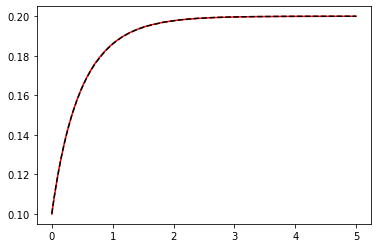

In [6]:
coef_index = 1
coefs = np.transpose(sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string, temp_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_index)
print(coefs.shape, feature_names[coef_index])

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    resid = eval(eval_string)
    return resid


u0 = [0.1]
du0 = [-0.04]
tspan = (0.0,5.0)
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, u0, tspan, differential_vars=differential_vars)
plt.plot(t, integrate.odeint(enzyme_deriv, u0[0], t), 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

In [30]:
# define parameters
r = 4
dt = 0.1
T = 20
t = np.arange(0, T + dt, dt)
# control input
F_train = -0.2 + 0.5 * np.sin(6 * t)
F_train[t > 16.0] = 0.0
#F_test = -1 + np.sin(t) + 3 * np.sin(2 * t)
F_test = -0.5 + 0.2 * np.sin(t) + 0.3 * np.sin(2 * t)
F_test[t > 2.0] = 0.0

x0 = [0.3, 0, 1, 0]
x_train = integrate.odeint(pendulum_on_cart_deriv, x0, t)
#x0 = [0.1, 0, 0.1, 0]
x0_test = [np.pi, 0, 0, 0]
x_test = integrate.odeint(pendulum_on_cart_deriv, x0_test, t)

# define hyperparameters
threshold = 1e-1

xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))

x_library_functions = [lambda x:1, lambda x:x, lambda x:cos(x), lambda x:sin(x),
                       lambda x, y: sin(x) * sin(y), lambda x, y: sin(x) * cos(y),
                       lambda x, y: cos(x) * cos(y)]
xdot_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x:'cos(' + x + ')', lambda x: 'sin(' + x + ')',
                          lambda x, y: 'sin(' + x + ')' + 'sin(' + y + ')', 
                          lambda x, y: 'sin(' + x + ')' + 'cos(' + y + ')',
                          lambda x, y: 'cos(' + x + ')' + 'cos(' + y + ')',
                          lambda x:'', lambda x:x, lambda x: x + x] 
# library_function_names = [lambda x:'', lambda x:x, lambda x:x, lambda x:x,
#                           lambda x, y: x + y, 
#                           lambda x, y: x + y, 
#                           lambda x, y: x + y, 
#                           lambda x:'', lambda x:x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 is the default values used for cvxpy
# and differs from the normal definition in PySINDy
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=2000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t) #, u=F_train)
print(model.get_feature_names())
print(np.shape(model.get_feature_names()))
#model.print()

(199, 4)
[[ 4.94181042e-11 -8.45048921e-07 -4.61473781e-08 ...  2.56961644e-07
   6.47548209e-06 -1.68897678e-05]
 [ 1.73379983e-07  3.52283694e-10  1.17682744e-07 ...  1.62221022e-06
  -2.16872187e-05 -2.92938906e-05]
 [ 4.60186812e-02  4.63303652e-08  1.28530531e-10 ...  1.29335354e-06
  -1.36549372e-05  2.12338877e-05]
 ...
 [ 4.68192568e-04  9.38143119e-05 -4.28374576e-06 ...  2.01013598e-08
   2.19051147e-02  9.07507799e-03]
 [ 2.11274276e-04 -9.46006717e-05  3.07360268e-05 ...  1.08472040e-02
   4.22412424e-09  6.41389570e-01]
 [ 8.06329118e-05  1.41309269e-05 -1.58673311e-06 ... -1.45215217e-02
   1.29471138e+00  1.63023134e-09]]
['', 'xdot0', 'xdot1', 'xdot2', 'xdot3', 'xdot0xdot0', 'xdot1xdot1', 'xdot2xdot2', 'xdot3xdot3', 'x0', 'x1', 'x2', 'x3', 'x0xdot0', 'x0xdot1', 'x0xdot2', 'x0xdot3', 'x1xdot0', 'x1xdot1', 'x1xdot2', 'x1xdot3', 'x2xdot0', 'x2xdot1', 'x2xdot2', 'x2xdot3', 'x3xdot0', 'x3xdot1', 'x3xdot2', 'x3xdot3', 'x0xdot0xdot0', 'x0xdot1xdot1', 'x0xdot2xdot2', 'x0xdot3xd

In [31]:
print(np.shape(sindy_opt.Theta), np.shape(sindy_opt.coef_))

(199, 279) (279, 279)


(199, 4)
(201, 4) (199, 279)


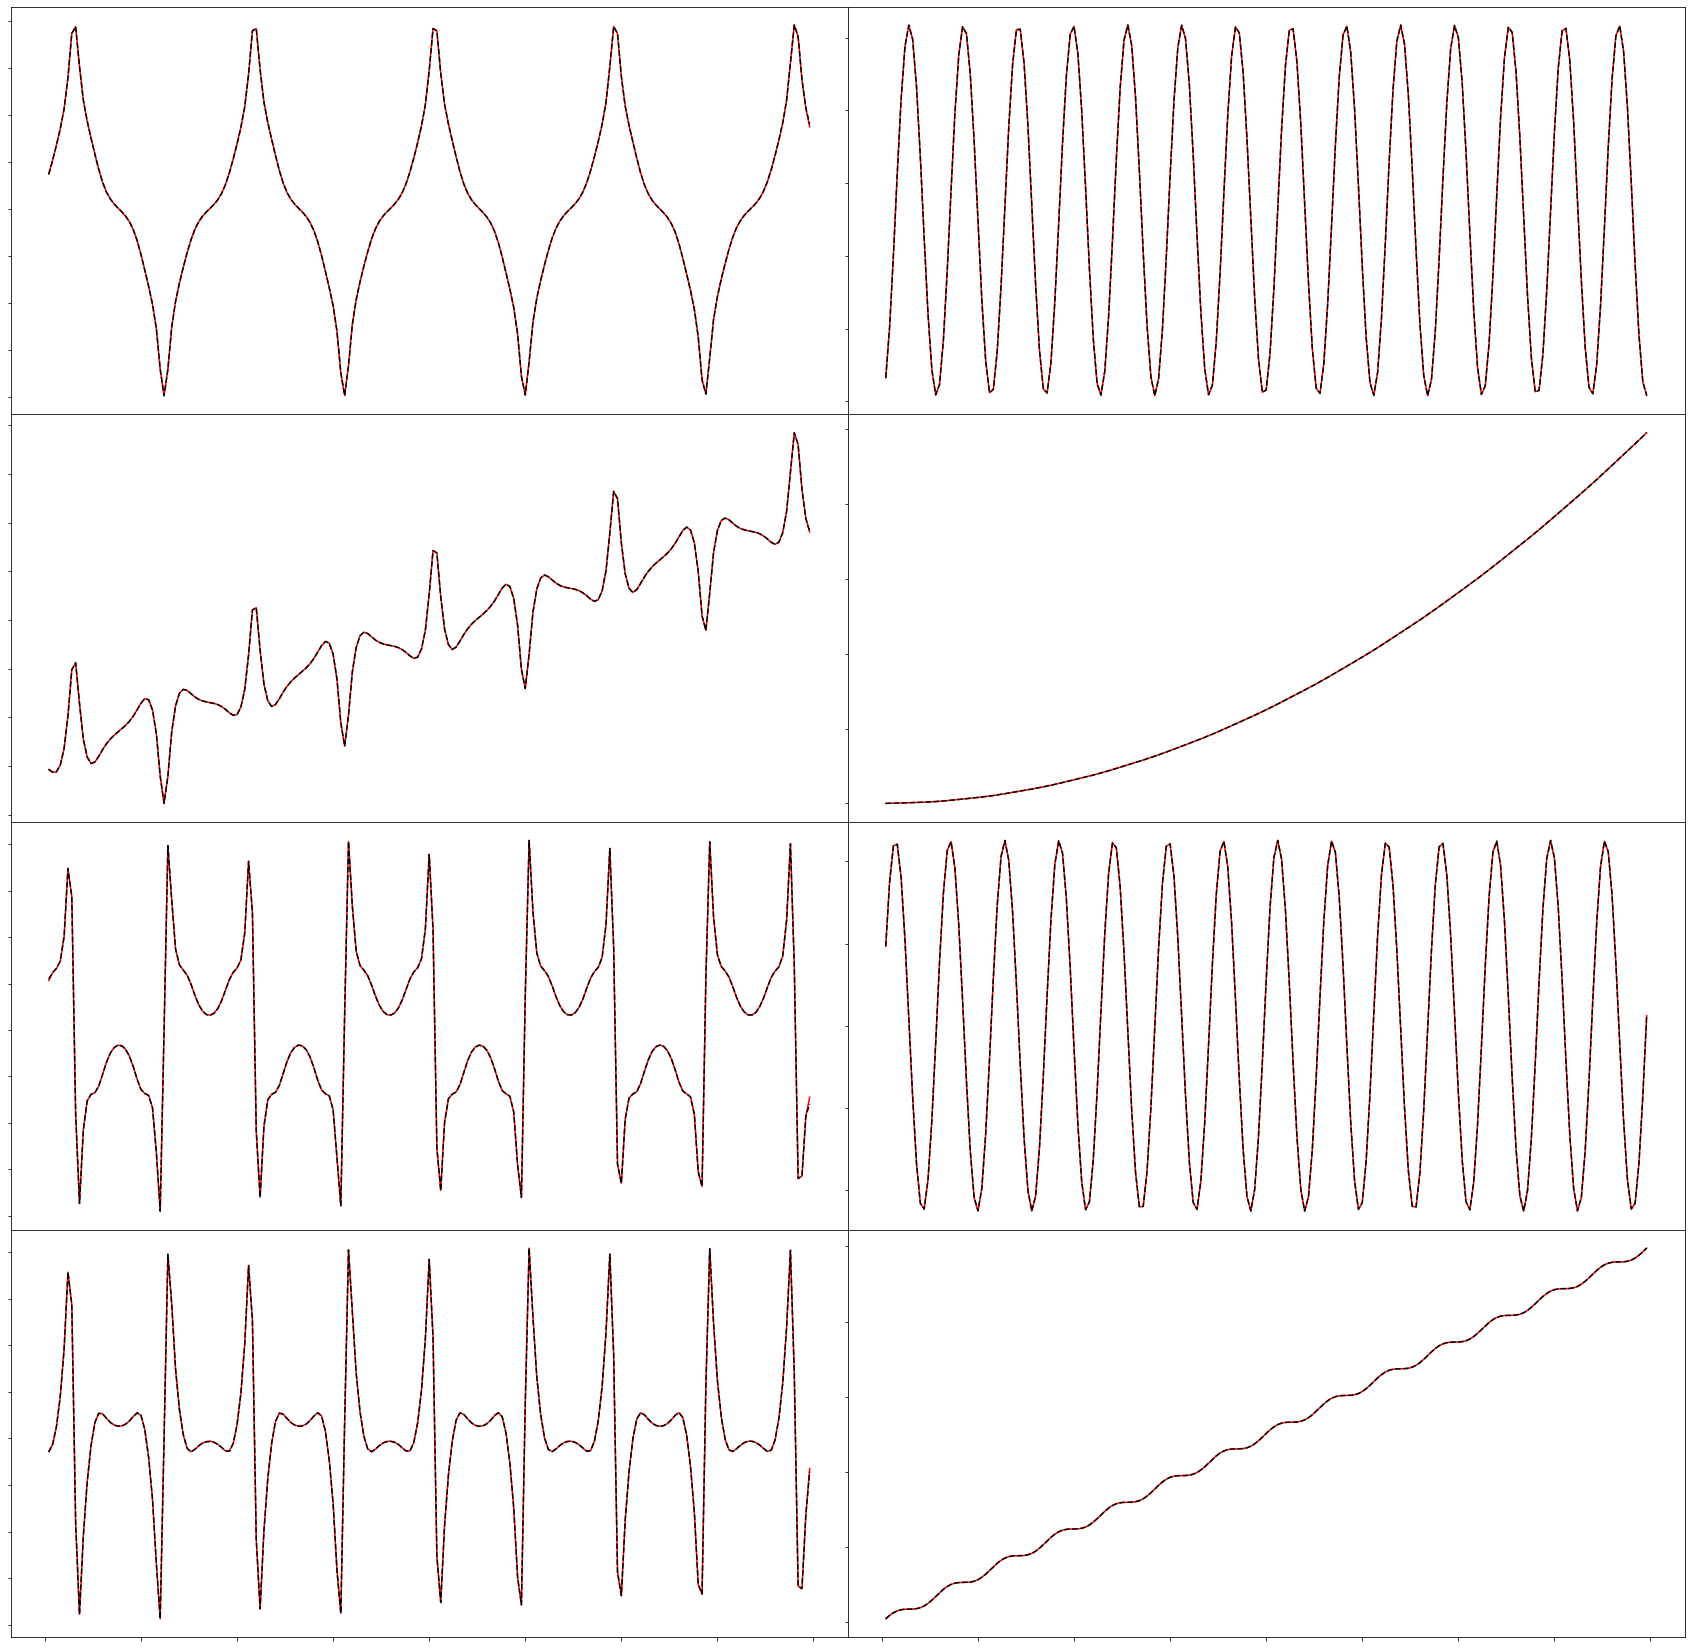

In [32]:
xdot_test = model.differentiate(x_train, t=t)[1:-1, :]
print(xdot_test.shape)
xdot_test_pred = sindy_opt.Theta @ np.transpose(sindy_opt.coef_)
print(x_test.shape, xdot_test_pred.shape)
make_fits(r, t[1:-1], xdot_test, xdot_test_pred[:, 1:1+r], x_test[1:-1], x_test[1:-1], 'pendulum_on_cart')

In [ ]:
coef_index = 1
r = 4
coefs = np.transpose(sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string, temp_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index)
print(eval_string)

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    return resid


u0 = np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 50)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
#plt.plot(t, integrate.odeint(pendulum_on_cart_deriv, u0, t), 'r')
plt.plot(sol.t, sol.u, 'k--')
print(sol)

0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]
58 cos(u[2])*du[1]
59 cos(u[2])*du[2]
60 cos(u[2])*du[3]
61 cos(u[3])*du[0]
62 cos(u[3])*du[1]
63 cos(u[3])*du

In [ ]:
np.shape(sol.u)

In [ ]:
colors = ['r', 'b', 'g', 'k']
x_test = integrate.odeint(pendulum_on_cart_deriv, u0, t)
for i in range(r):
    plt.plot(t, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
plt.legend()

In [13]:
sol.u

[array([0.00572153, 0.24927114, 0.64532704, 0.41083891])]